In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from glob import glob
import pickle
import os

import numpy as np
import cv2

In [2]:
calibration_images = glob(os.path.join("camera_cal", "calibration*.jpg"))

In [3]:
object_points = []
image_points = []

obj_point = np.zeros((9*6, 3), np.float32)
obj_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [4]:
for cal_image in calibration_images:
    img = cv2.imread(cal_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret:
        image_points.append(corners)
        object_points.append(obj_point)

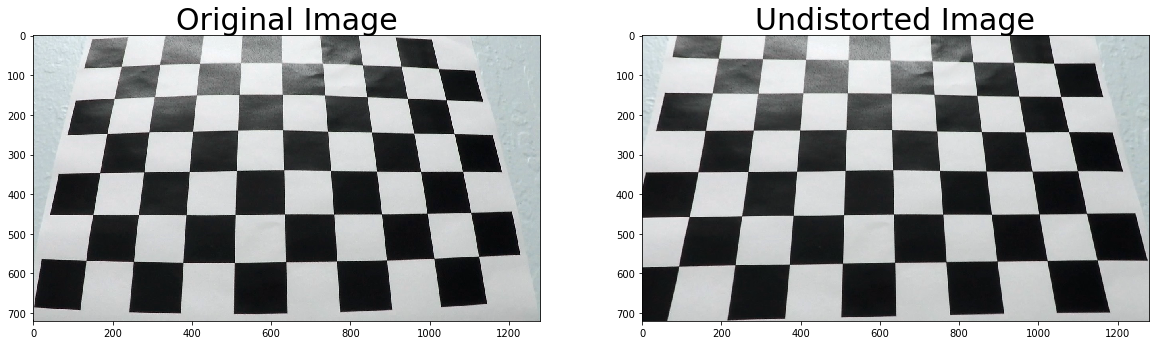

In [5]:
test_image_path = os.path.join("camera_cal", "calibration3.jpg")
test_image = cv2.imread(test_image_path)
img_size = (test_image.shape[1], test_image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
dst = cv2.undistort(test_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ))

## Color and thresholds

In [38]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_img

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(abs_sobel)
    dir_binary[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1
    return dir_binary

In [9]:
img = cv2.imread("test_images/test1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

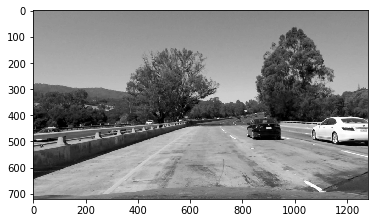

In [14]:
plt.imshow(gray, cmap='gray')

In [19]:
S = hls[:, :, 2]

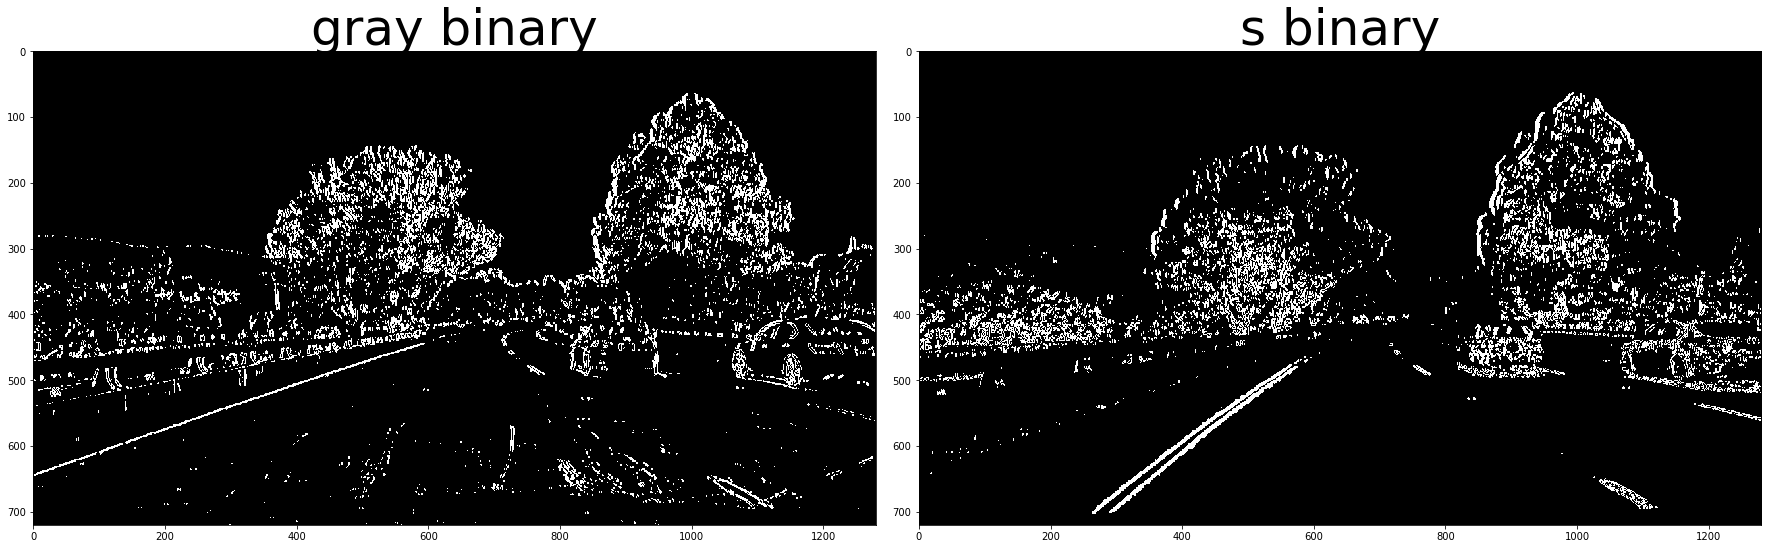

In [24]:
gray_binary = abs_sobel_thresh(gray, sobel_kernel=5, thresh=(20, 100))
s_binary = abs_sobel_thresh(S, sobel_kernel=5, thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray_binary, cmap='gray')
ax1.set_title('gray binary', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('s binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

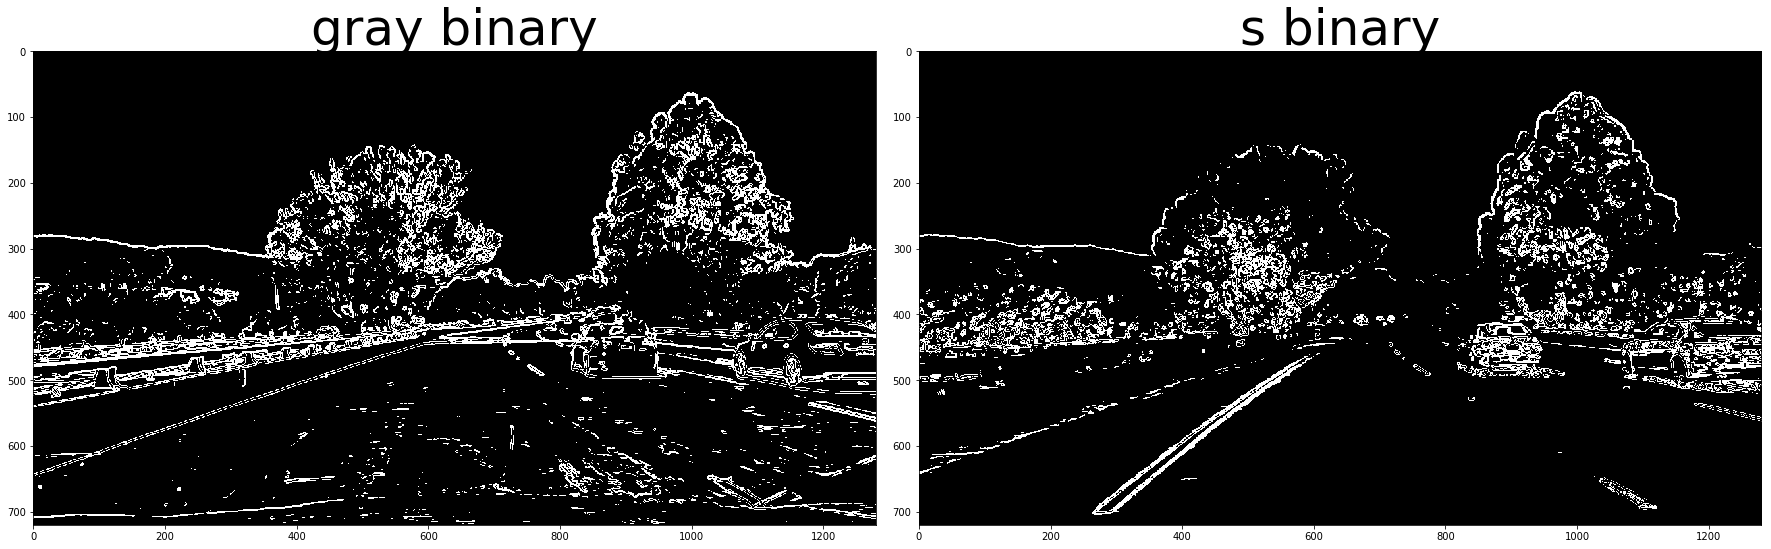

In [32]:
gray_binary = mag_thresh(gray, sobel_kernel=5, thresh=(30, 100))
s_binary = mag_thresh(S, sobel_kernel=5, thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray_binary, cmap='gray')
ax1.set_title('gray binary', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('s binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

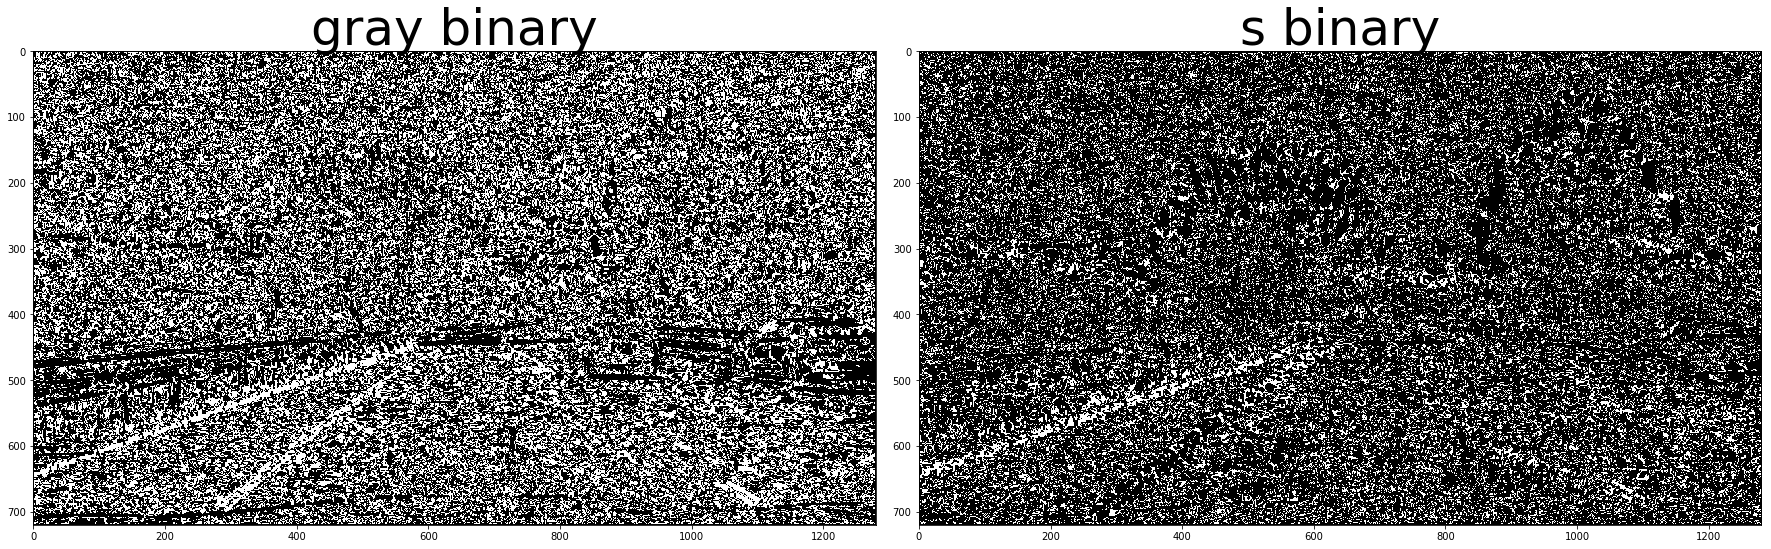

In [48]:
gray_binary = dir_threshold(gray, sobel_kernel=9, thresh=(0.7, 1.3))
s_binary = dir_threshold(S, sobel_kernel=9, thresh=(1.0, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray_binary, cmap='gray')
ax1.set_title('gray binary', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('s binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

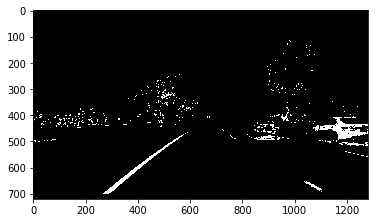

In [54]:
s_binary = np.zeros_like(S)
s_binary[(S >= 150) & (S <= 255)] = 1
plt.imshow(s_binary, cmap='gray')

## Perspective transform

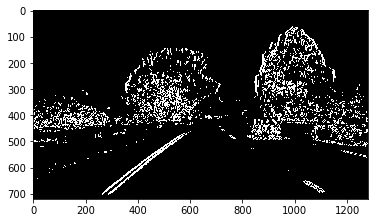

In [86]:
s_binary = abs_sobel_thresh(S, sobel_kernel=9, thresh=(20, 100))
plt.imshow(s_binary, cmap='gray')

In [87]:
s_binary.shape

(720, 1280)

In [138]:
src = np.float32([[200, 720], [560, 470], [670, 450], [1200, 720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])

In [90]:
pts = np.array([[200, 720], [580, 470], [670, 470], [1200, 720]], np.int32)
test = cv2.polylines(np.zeros_like(s_binary), [pts], True, (255,0, 0), 10)
superposed = cv2.addWeighted(s_binary, 0.8, test, 1.0, 0.0)

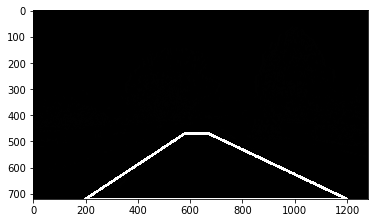

In [91]:
plt.imshow(superposed, cmap='gray')

In [139]:
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(s_binary, M, (1280, 720), flags=cv2.INTER_LINEAR)

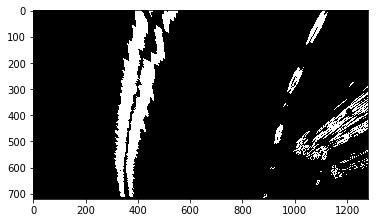

In [140]:
plt.imshow(warped, cmap='gray')